## Setup de librerías y datos

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

random.seed(10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("/content/drive/MyDrive/machine-learning/iris.csv", skiprows=1, header=None, names=col_names)

In [ ]:
train, validation = train_test_split(data,test_size=0.3, random_state=1)

## Funciones

In [ ]:
# funciones para comparacion
def gini(clase):
    class_label = np.unique(clase)
    dict1 = {}
    val_gini = 0
    n=len(clase)
    for i in class_label:
        dict1[i]=np.round(np.sum(clase==i)/n,2)
        val_gini += dict1[i]*(1-dict1[i])
    return dict1,np.round(val_gini,3)

def entropy(clase):
    class_label = np.unique(clase)
    dict1 = {}
    entropy = 0
    n=len(clase)
    for i in class_label:
        dict1[i]=np.round(np.sum(clase==i)/n,2)
        entropy += -dict1[i] * np.log2(dict1[i])    
    return dict1,np.round(entropy,3)
    
    

In [ ]:
def min_feature(dic1):
    min_val=2
    min_clase = ""
    for i in dic:
        if dic[i][-1]<min_val:
            min_val=dic[i][-1]
            min_clase = i
            mean_val = dic[i][0]
    return min_clase,min_val,mean_val

In [ ]:
def best_split_mean(data, method='gini'):
  columns = data.columns[0:data.shape[1]-1]
  min_gini_feature = 2
  min_class = ""
  result = {}

  gini_pond = 0
  index_der = []
  index_izq = []
  threshold = 0

  for c in columns:
    #Se divide la muestra en dos partes
    train_izq = data[data[c] <= data[c].mean()]
    train_der = data[data[c] > data[c].mean()]

    if (method=='gini'):
        #Se calcula el gini para cada parte
        indice_izq = gini(train_izq["type"])
        indice_der =gini(train_der["type"])
    else:
        #Se calcula la entropia para cada parte
        indice_izq = entropy(train_izq["type"])
        indice_der = entropy(train_der["type"])        

    gini_izq_n = train_izq.shape[0]
    gini_der_n = train_der.shape[0]
    gini_tot = gini_izq_n + gini_der_n

    #Se calcula los pesos para el gini ponderado
    w_izq = gini_izq_n/gini_tot
    w_der = gini_der_n/gini_tot

    #Se calcula el gini ponderado
    gini_pon = np.round(indice_izq[-1]*w_izq + indice_der[-1]*w_der,3)

    if gini_pon < min_gini_feature:
      min_gini_feature = gini_pon
      index_der = train_der.index
      index_izq = train_izq.index
      min_class = c
      threshold = data[c].mean()

  result[min_class] = {"ponderado": min_gini_feature, "threshold": threshold, "index_der": index_der, "index_izq": index_izq }

  return min_class, result

In [ ]:
def best_split(data, method='gini'):
  columns = data.columns[0:data.shape[1]-1]
  min_gini_feature = 2
  min_class = ""
  result = {}

  gini_pond = 0
  index_der = []
  index_izq = []
  threshold = 0

  for c in columns:
    #Se toman todos los puntos 
    dots = np.unique(data[c])
    for d in dots: #probamos con todos los puntos para incrementar el accuracy
      #Se divide la muestra en dos partes
      train_izq = data[data[c] <= d]
      train_der = data[data[c] > d]

      if (method=='gini'):
          #Se calcula el gini para cada parte
          indice_izq = gini(train_izq["type"])
          indice_der =gini(train_der["type"])
      else:
          #Se calcula la entropia para cada parte
          indice_izq = entropy(train_izq["type"])
          indice_der = entropy(train_der["type"])        

      gini_izq_n = train_izq.shape[0]
      gini_der_n = train_der.shape[0]
      gini_tot = gini_izq_n + gini_der_n

      #Se calcula los pesos para el gini ponderado
      w_izq = gini_izq_n/gini_tot
      w_der = gini_der_n/gini_tot

      #Se calcula el gini ponderado
      gini_pon = np.round(indice_izq[-1]*w_izq + indice_der[-1]*w_der,3)

      if gini_pon < min_gini_feature:
        min_gini_feature = gini_pon
        index_der = train_der.index
        index_izq = train_izq.index
        threshold = d
        min_class = c

  result[min_class] = {"ponderado": min_gini_feature, "threshold": threshold, "index_der": index_der, "index_izq": index_izq }

  return min_class, result

In [ ]:
# Diccionario con nodos finales
def nodosFin(lista):
    dict1 = {}
    for i in lista:
        if(i[0] != "NoIdent"):
            dict1[i[1][0] + i[-1]] = i[0]
    return dict1

# Todos del arbol
def allCortes(lista):
    dict2 = {}
    for i in lista:
        if i[1][0] not in dict2:
            dict2[i[1][0]] = [ i[1][1], i[1][2] ]

    return dict2

In [ ]:
def build_tree_mean(data, index, resultLst =[], depth = 0, direction = 'root', directions = '', method = 'gini' ):

  labels = np.unique(data.loc[index]["type"])

  if (len(labels) > 1):
    directions =  directions + direction
    bs_class, bs_data = best_split_mean(data.loc[index], method)
    reSplit = [directions, bs_class, bs_data[bs_class]['threshold']]
                
    left_indexes = bs_data[bs_class]["index_izq"]
    resultL = build_tree(data, left_indexes, resultLst, depth+1, 'L', directions)
               
    right_indexes = bs_data[bs_class]["index_der"]    
    resultR = build_tree(data, right_indexes, resultLst, depth+1,'R', directions)
    
    if resultL == None:
        resultL = "NoIdent"

    if resultR == None:
        resultR = "NoIdent"        
        
    resultLst.insert(0, [resultR, reSplit, "R"])        
    resultLst.insert(0, [resultL, reSplit, "L"])
               
  else:
    return labels[0]

In [ ]:
def build_tree(data, index, resultLst =[], depth = 0, direction = 'root', directions = '', method = 'gini' ):

  labels = np.unique(data.loc[index]["type"])

  if (len(labels) > 1):
    directions =  directions + direction
    bs_class, bs_data = best_split(data.loc[index], method)
    reSplit = [directions, bs_class, bs_data[bs_class]['threshold']]
                
    left_indexes = bs_data[bs_class]["index_izq"]
    resultL = build_tree(data, left_indexes, resultLst, depth+1, 'L', directions)
               
    right_indexes = bs_data[bs_class]["index_der"]    
    resultR = build_tree(data, right_indexes, resultLst, depth+1,'R', directions)
    
    if resultL == None:
        resultL = "NoIdent"

    if resultR == None:
        resultR = "NoIdent"        
        
    resultLst.insert(0, [resultR, reSplit, "R"])        
    resultLst.insert(0, [resultL, reSplit, "L"])
               
  else:
    return labels[0]

In [ ]:
def clasificar(x, trainInfo):
    # Se generan los diccionarios para extraer los datos
    cortes = allCortes(trainInfo)    
    hojas = nodosFin(trainInfo)
    
    # Se ejecuta un metodo iterativo comenzando con la raiz
    actual = "root"
    brazos = ["L","R"]
    
    # Variable de resultado
    result = ""
    
    # Se busca con centinela
    centi = 1
    while centi == 1 :
        # Caracteristica para cortar y punto de corte
        charCorte = cortes[actual][0]
        puntCorte = cortes[actual][1]
        
        # Se evalua segun la caracteristica y punto de corte
        if x[charCorte] <= puntCorte :
            actual += brazos[0]
        else:
            actual += brazos[1]            
    
        # Se busca si es una hoja final
        if actual in hojas:
            result = hojas[actual]
            centi = 0   # Se sale del loop                
        
    return result

In [ ]:
def voting(row):
  array = np.array(row)
  return stats.mode(array)[0][0]

In [ ]:
def print_confusion_matrix(y_true, y_pred):
  labels=["versicolor", "virginica", "setosa"]
  cm = confusion_matrix(y_true, y_pred, labels = labels, normalize='true')
  #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()
  plt.show()

# Experimentos

### Análisis con un solo punto de corte en la media

In [ ]:
tree = []
build_tree_mean(train, train.index, tree, method = 'gini')

validation_dt_mean = validation.copy()
validation_dt_mean['predict'] = validation.apply(lambda row: clasificar(row, tree), axis=1) 

print("Accuracy:", np.mean(validation_dt_mean.type == validation_dt_mean.predict) * 100)
validation_dt_mean[validation_dt_mean.type != validation_dt_mean.predict]

Accuracy: 95.55555555555556


,sepal_length,sepal_width,petal_length,petal_width,type,predict
77,6.7,3.0,5.0,1.7,versicolor,virginica
119,6.0,2.2,5.0,1.5,virginica,versicolor


In [ ]:
tree

[['NoIdent', ['root', 'petal_length', 3.739047619047619], 'L'],
 ['NoIdent', ['root', 'petal_length', 3.739047619047619], 'R'],
 ['NoIdent', ['rootR', 'petal_width', 1.6], 'L'],
 ['NoIdent', ['rootR', 'petal_width', 1.6], 'R'],
 ['NoIdent', ['rootRR', 'petal_length', 4.8], 'L'],
 ['virginica', ['rootRR', 'petal_length', 4.8], 'R'],
 ['virginica', ['rootRRL', 'sepal_width', 3.0], 'L'],
 ['versicolor', ['rootRRL', 'sepal_width', 3.0], 'R'],
 ['versicolor', ['rootRL', 'petal_length', 4.9], 'L'],
 ['NoIdent', ['rootRL', 'petal_length', 4.9], 'R'],
 ['versicolor', ['rootRLR', 'sepal_length', 6.0], 'L'],
 ['virginica', ['rootRLR', 'sepal_length', 6.0], 'R'],
 ['setosa', ['rootL', 'petal_length', 1.9], 'L'],
 ['versicolor', ['rootL', 'petal_length', 1.9], 'R']]

### Análisis con todos los puntos de cada característica

In [ ]:
tree = []
build_tree(train, train.index, tree, method = 'gini')

validation_dt_dots = validation.copy()
validation_dt_dots['predict'] = validation.apply(lambda row: clasificar(row, tree), axis=1) 

print("Accuracy:", np.mean(validation_dt_dots.type == validation_dt_dots.predict) * 100)
validation_dt_dots[validation_dt_dots.type != validation_dt_dots.predict]

Accuracy: 95.55555555555556


,sepal_length,sepal_width,petal_length,petal_width,type,predict
77,6.7,3.0,5.0,1.7,versicolor,virginica
119,6.0,2.2,5.0,1.5,virginica,versicolor


In [ ]:
tree

[['setosa', ['root', 'petal_length', 1.9], 'L'],
 ['NoIdent', ['root', 'petal_length', 1.9], 'R'],
 ['NoIdent', ['rootR', 'petal_width', 1.6], 'L'],
 ['NoIdent', ['rootR', 'petal_width', 1.6], 'R'],
 ['NoIdent', ['rootRR', 'petal_length', 4.8], 'L'],
 ['virginica', ['rootRR', 'petal_length', 4.8], 'R'],
 ['virginica', ['rootRRL', 'sepal_width', 3.0], 'L'],
 ['versicolor', ['rootRRL', 'sepal_width', 3.0], 'R'],
 ['versicolor', ['rootRL', 'petal_length', 4.9], 'L'],
 ['NoIdent', ['rootRL', 'petal_length', 4.9], 'R'],
 ['versicolor', ['rootRLR', 'sepal_length', 6.0], 'L'],
 ['virginica', ['rootRLR', 'sepal_length', 6.0], 'R']]

## Gini

### Simple decision tree

In [ ]:
tree = []
build_tree(train, train.index, tree, method = 'gini')

validation_dt = validation.copy()
validation_dt['predict'] = validation.apply(lambda row: clasificar(row, tree), axis=1) 

print("Accuracy:", np.mean(validation_dt.type == validation_dt.predict) * 100)
validation_dt[validation_dt.type != validation_dt.predict]

Accuracy: 95.55555555555556


,sepal_length,sepal_width,petal_length,petal_width,type,predict
77,6.7,3.0,5.0,1.7,versicolor,virginica
119,6.0,2.2,5.0,1.5,virginica,versicolor


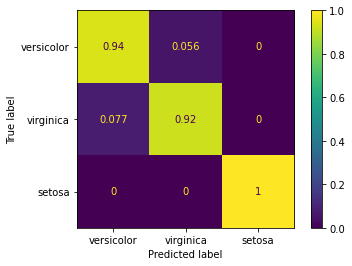

In [ ]:
# Generando la matriz de confución
y_true = np.array(validation_dt["type"])
y_pred = np.array(validation_dt["predict"])
print_confusion_matrix(y_true, y_pred)


### Bagging

In [ ]:
# Implementar Bagging
random.seed(10)

draws = 5 
valididation_bagging = validation.copy()
samps = ['new1', 'new2','new3','new4','new5']

for ix in range(0,draws):
    sample = pd.concat([train.sample(frac=0.5, replace=True, random_state=1), 
                        train.sample(frac=0.5, replace=True, random_state=1)], 
                        axis=0)
    tree = []
    build_tree(sample, sample.index, tree, method = 'gini')
    valididation_bagging[samps[ix]] = validation.apply(lambda row: clasificar(row, tree), axis=1) 

valididation_bagging["voting"] = valididation_bagging[samps].apply(lambda row: voting(row), axis=1) 

In [ ]:
print("Accuracy:", np.mean(valididation_bagging.type == valididation_bagging.voting) * 100)
valididation_bagging[valididation_bagging.type != valididation_bagging.voting]

Accuracy: 97.77777777777777


,sepal_length,sepal_width,petal_length,petal_width,type,new1,new2,new3,new4,new5,voting
77,6.7,3.0,5.0,1.7,versicolor,virginica,virginica,virginica,virginica,virginica,virginica


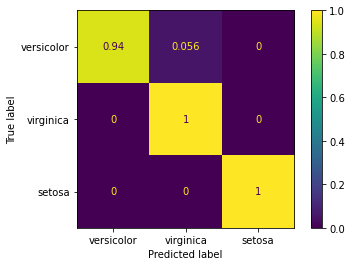

In [ ]:
# Generando la matriz de confución
y_true = np.array(valididation_bagging["type"])
y_pred = np.array(valididation_bagging["voting"])
print_confusion_matrix(y_true, y_pred)

### Random Forest

In [ ]:
# Implementar Random-Forest
random.seed(100)

validation_rf = validation.copy()
for ix in range(0,draws) :
    sample = pd.concat([train.sample(frac=0.5, replace=True, random_state=1), 
                        train.sample(frac=0.5, replace=True, random_state=1)], 
                       axis=0)
    # Reduccion de caracteristicas
    features = random.sample(list(train.columns)[:-1], k=3)
    features.append('type')
    sample = sample.loc[:,features]
    tree = []
    build_tree(sample, sample.index, tree, method = 'gini')
    validation_rf[samps[ix]] = validation.apply(lambda row: clasificar(row, tree), axis=1) 

validation_rf["voting"] = validation_rf[samps].apply(lambda row: voting(row), axis=1) 

In [ ]:
print("Accuracy:", np.mean(validation_rf.type == validation_rf.voting) * 100)
validation_rf[validation_rf.type != validation_rf.voting]


Accuracy: 97.77777777777777


,sepal_length,sepal_width,petal_length,petal_width,type,new1,new2,new3,new4,new5,voting
77,6.7,3.0,5.0,1.7,versicolor,virginica,virginica,virginica,virginica,virginica,virginica


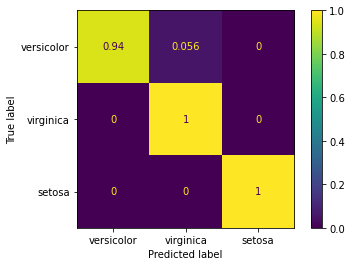

In [ ]:
# Generando la matriz de confución
y_true = np.array(validation_rf["type"])
y_pred = np.array(validation_rf["voting"])
print_confusion_matrix(y_true, y_pred)

## Entropy

### Simple decision tree

In [ ]:
tree = []
build_tree(train, train.index, tree, method = 'entropy')

validation_dt_e = validation.copy()
validation_dt_e['predict'] = validation.apply(lambda row: clasificar(row, tree), axis=1) 

print("Accuracy:", np.mean(validation_dt_e.type == validation_dt_e.predict) * 100)
validation_dt_e[validation_dt_e.type != validation_dt_e.predict]

Accuracy: 95.55555555555556


,sepal_length,sepal_width,petal_length,petal_width,type,predict
77,6.7,3.0,5.0,1.7,versicolor,virginica
119,6.0,2.2,5.0,1.5,virginica,versicolor


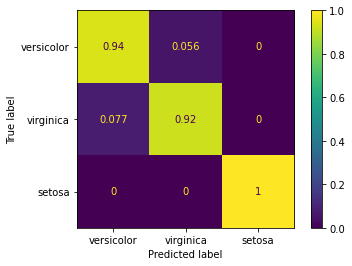

In [ ]:
# Generando la matriz de confución
y_true = np.array(validation_dt_e["type"])
y_pred = np.array(validation_dt_e["predict"])
print_confusion_matrix(y_true, y_pred)

### Bagging

In [ ]:
# Implementar Bagging
random.seed(10)

draws = 5 
perc = 0.6
valididation_bagging_e = validation.copy()
samps = ['new1', 'new2','new3','new4','new5']

for ix in range(0,draws):
    sample = pd.concat([train.sample(frac=0.5, replace=True, random_state=1), train.sample(frac=0.5, replace=True, random_state=1)], axis=0)
    tree = []
    build_tree(sample, sample.index, tree, method = 'entropy')
    valididation_bagging_e[samps[ix]] = validation.apply(lambda row: clasificar(row, tree), axis=1) 

valididation_bagging_e["voting"] = valididation_bagging_e[samps].apply(lambda row: voting(row), axis=1) 

In [ ]:
print("Accuracy:", np.mean(valididation_bagging_e.type == valididation_bagging_e.voting) * 100)
valididation_bagging_e[valididation_bagging_e.type != valididation_bagging_e.voting]

Accuracy: 97.77777777777777


,sepal_length,sepal_width,petal_length,petal_width,type,new1,new2,new3,new4,new5,voting
77,6.7,3.0,5.0,1.7,versicolor,virginica,virginica,virginica,virginica,virginica,virginica


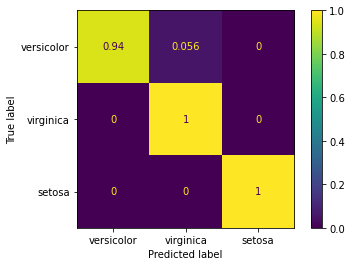

In [ ]:
# Generando la matriz de confución
y_true = np.array(valididation_bagging_e["type"])
y_pred = np.array(valididation_bagging_e["voting"])
print_confusion_matrix(y_true, y_pred)

### Random Forest

In [ ]:
# Implementar Random-Forest
random.seed(10)

validation_rf_e = validation.copy()
for ix in range(0,draws) :
    sample = pd.concat([train.sample(frac=0.5, replace=True, random_state=1), 
                        train.sample(frac=0.5, replace=True, random_state=1)], 
                       axis=0)
    # Reduccion de caracteristicas
    features = random.sample(list(train.columns)[:-1], k=3)
    features.append('type')
    sample = sample.loc[:,features]
    tree = []
    build_tree(sample, sample.index, tree, method = 'entropy')
    validation_rf_e[samps[ix]] = validation.apply(lambda row: clasificar(row, tree), axis=1) 

validation_rf_e["voting"] = validation_rf_e[samps].apply(lambda row: voting(row), axis=1) 

In [ ]:
print("Accuracy:", np.mean(validation_rf_e.type == validation_rf_e.voting) * 100)
validation_rf_e[validation_rf_e.type != validation_rf_e.voting]


Accuracy: 97.77777777777777


,sepal_length,sepal_width,petal_length,petal_width,type,new1,new2,new3,new4,new5,voting
77,6.7,3.0,5.0,1.7,versicolor,virginica,virginica,virginica,virginica,virginica,virginica


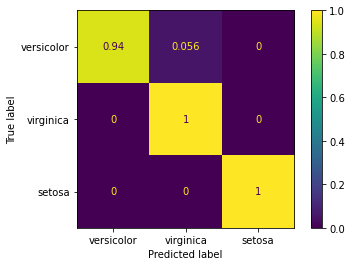

In [ ]:
# Generando la matriz de confución
y_true = np.array(validation_rf_e["type"])
y_pred = np.array(validation_rf_e["voting"])
print_confusion_matrix(y_true, y_pred)